## CS4305TU Applied Machine Learning. Week 8 Assignment (Recurrent Neural Networks)

### Short-term Drinking Water Demand Forecasting with Deep Learning Techniques


Welcome to the assignment for Week 8 of your Applied Machine Learning course. In this assigment, you will be tasked with _forecasting drinking water demands (up to 24 hours ahead) in urban areas_ using Deep Learning techniques. 

<u> Background </u>

Water Distribution Systems (WDS) are networked infrastructures designed to provide drinking water to citizens and businesses. Like other critical infrastructure, modern WDS rely on digitalisation to optimize their operations in order to maximise efficiency by ensuring sustainable water management practices.

Digitalisation allows gathering and analysing sensor data to inform control strategies. For instance, accurate forecasting of _drinking water demands_ over shor-time horizons (e.g., 24 hours) can be used to better manage the operations of the pumping stations of the WDS, as well as optimizing the production of drinking water from water treatment plants.

Water demand time series are usually recorded by flow meters located at the inlet of a district. This data can then be used to develop forecasting methods, which are usually based on time series analysis techniques or, more recently, machine learning (ML). Typical input data for these models are past water demands, meteorological data, and calendar information (e.g., day of the week, holidays, important events, ...).


<br/>


 

<center><figure>
  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0377042716300565-gr6_lrg.jpg" width=600/>
<figcaption>Figure 1. Water demand forecasting: observed data vs machine learning prediction. 
    
<sub><sup>Image credits: Brentan et al. (2017), https://doi.org/10.1016/j.wroa.2019.100028 </sup></sub></figcaption>
</figure></center>

<u> Problem defintion </u>

The data for this assignment was kindly provided by the authors of [1]. The data refers to hourly measurments from a real WDS serving around 120k users (residential and industrial) of a medium-sized city of Northern Italy.

The data spans two years. You will be using the data in "Year #1" to _train_ and _validate_ different Deep Learning (DL) models based on Feed Forward Neural Networks and Recurrent Neural Networks. The performance of these models will then be evaluated on "Year #2", the _test_ dataset. Available data includes hourly average water demand in [L/s] (liters per second). Other calendar information or meteorological data is not found to provide substantial gains in predictive performances.

<b> Your goal is to build autoregressive Deep Learning models that forecast hourly water demand for the next 24 hours </b> (e.g., 24 outputs) using as input 1 week (e.g., 168 hours) of past water demand and calendar information (e.g., the _day_ boolean variable)

<u> References </u>

[1] Pacchin, E., Gagliardi, F., Alvisi, S. and Franchini, M., 2019. A comparison of short-term water demand forecasting models. Water resources management, 33(4), pp.1481-1497.


### Part 0. Exploratory data analysis

#### Link to Google Drive and Load python modules

In [ ]:
# link to Google Drive to access files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!ls gdrive 

In [2]:
# install tensorflow addons (hint: it has a method to stop training after a certain time has passed)
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [3]:
# generic modules
import datetime, os
import itertools
import time

# append working folder
import sys
#working_folder = 'PLEASE INSERT HERE YOUR WORKING FOLDER'
#sys.path.append(working_folder)

# basic data science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# keras
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import tensorflow_addons as tfa

# sklearn helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import additional helper scripts 
# (note: the file assignment_utils.py should be in the working_folder specified earlier in this cell)
import assignment_utils

#### Exploratory data analysis

In [4]:
# load water demand data
df_year1 = pd.read_csv('water_demand_Y1.txt',header=None, sep=r"\s+")
df_year2 = pd.read_csv('water_demand_Y2.txt',header=None, sep=r"\s+")

Let's visualize the typical pattern of a random day in our data. In general, these patterns show two peaks of consumption: in the morning and in the evening. Consumption is at its lowest during late night and early mornings.

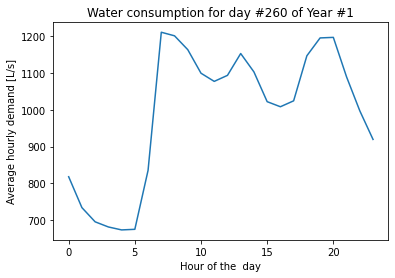

In [5]:
# plot random day
day_ix = np.random.randint(len(df_year1))
ax = df_year1.loc[day_ix].plot()
ax.set_xlabel('Hour of the  day');
ax.set_ylabel('Average hourly demand [L/s]');
ax.set_title(f'Water consumption for day #{day_ix} of Year #1');

We can obtain more information on the hour-by-hour distribution of the water demand by using boxplots. These are computed across all days for each hour of the day. By plotting the distribution for both years we see that <u> consumptions increased in Year #2 </u>. This also emerges from the overall average (red line).

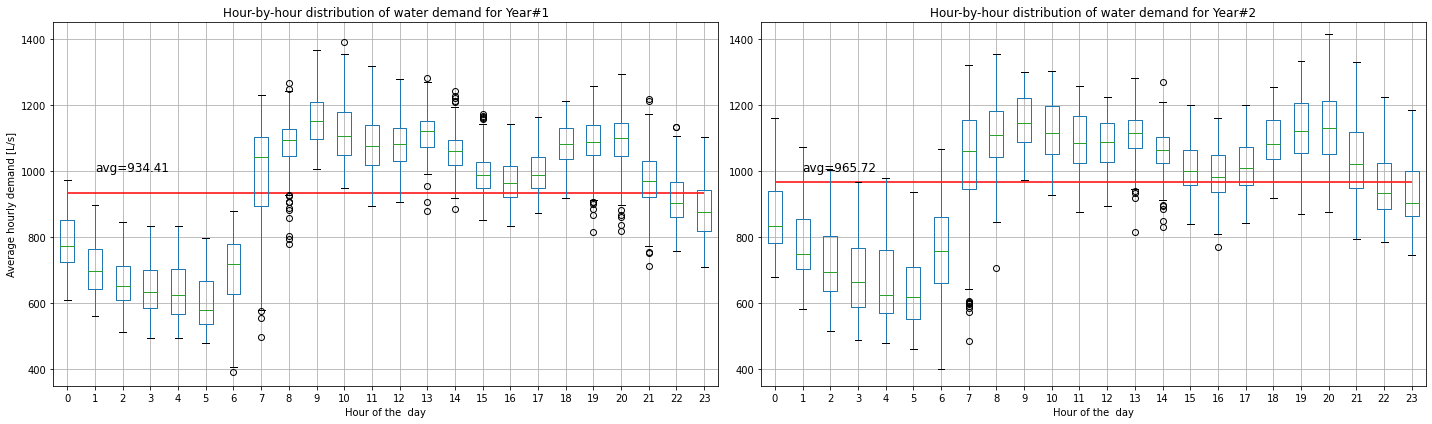

In [6]:
# plot hourly water demand distributions across all days

# year 1
f, axes = plt.subplots(1,2,figsize=(20,6))
df_year1.boxplot(ax=axes[0])
axes[0].set_xlabel('Hour of the  day');
axes[0].set_ylabel('Average hourly demand [L/s]');
axes[0].set_title('Hour-by-hour distribution of water demand for Year#1');
axes[0].set_ylim([350,1450])

avg_year1 = df_year1.values.reshape(-1).mean()
axes[0].hlines(avg_year1,1,24, colors='r')
axes[0].text(2, 1000, f'avg={avg_year1:.2f}', fontsize=12)

# year 2
df_year2.boxplot(ax=axes[1])
axes[1].set_xlabel('Hour of the  day');
# axes[1].set_ylabel('Average hourly demand [L/s]');
axes[1].set_title('Hour-by-hour distribution of water demand for Year#2');
axes[1].set_ylim([350,1450])

avg_year2 = df_year2.values.reshape(-1).mean()
axes[1].hlines(avg_year2,1,24, colors='r')
axes[1].text(2, 1000, f'avg={avg_year2:.2f}', fontsize=12)

f.tight_layout()

#### Creation of sequence-to-sequence modeling dataset and data normalization

We now create the sequence datasets for _training_, _validating_ and _testing_ our DL methods. We will start by only using past water demands. These datasets will be created by calling one of the helper functions in the ```assignment_utils``` module. We first create the sequences for Year \#1, which will be used for training and validation.

In [7]:
T = 168 # number of time steps to use for prediction (168 hours = 1 week)
H = 24  # number of time steps to predict (24 hours)
X,Y=assignment_utils.create_sequences(df_year1.values.reshape(-1),T=T,H=H)
print(X.shape)
print(Y.shape)

(8568, 168)
(8568, 24)


As you can see, each input-ouput pair is made of: 1) an input sequence of 168 hours (e.g., 1 week) and 2) an output sequence of 24 hours.

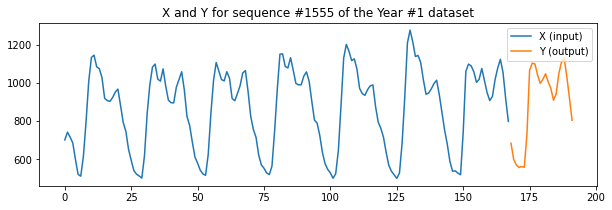

In [8]:
random_ix = np.random.choice(X.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X[0], label='X (input)')
ax.plot(np.arange(T,T+H),Y[0], label = 'Y (output)')
ax.set_title(f'X and Y for sequence #{random_ix} of the Year #1 dataset');
ax.legend();

These sequences are not normalized yet, and we need to split them into training and validation. We first perform the latter task and then we use ```scale_sequences``` to perform the scaling. Is important to use the scaler "fitted" for the training dataset to scale tha validation dataset and then the test dataset (Year \#2). Since the input and output variables are both water demand, we only need to fit one scaler. ```scale_sequences``` recognize whether to fit a scaler or use an existing one based on the arguments it receives when called.

In [9]:
# we use 15% of Year #1 for validation; we shuffle the sequences; 
# we keep track of indexes of train and validation.
X_tra, X_val, Y_tra, Y_val, ix_tra, ix_val = train_test_split(
    X, Y, np.arange(X.shape[0]), test_size=0.15, shuffle=True, random_state=42)
print(f"X_tra.shape: {X_tra.shape}, Y_tra.shape: {Y_tra.shape}")
print(f"X_val.shape: {X_val.shape}, Y_val.shape: {Y_val.shape}")

X_tra.shape: (7282, 168), Y_tra.shape: (7282, 24)
X_val.shape: (1286, 168), Y_val.shape: (1286, 24)


Let's plot a random sequence from the training dataset

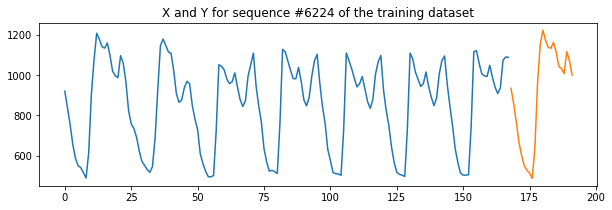

In [10]:
random_ix = np.random.choice(X_tra.shape[0])
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_tra[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_tra[random_ix], label = 'Ytra')
ax.set_title(f'X and Y for sequence #{random_ix} of the training dataset');

Now we scale all data. Remember: <u>you "fit" the scaler using training data </u>; when you develop your machine learning models, you have to assume that you have no information on validation and test data.

In [11]:
X_tra, scaler = assignment_utils.scale_sequences(X_tra,scaler_type='minmax')
Y_tra, _ = assignment_utils.scale_sequences(Y_tra, scaler)
X_val, _ = assignment_utils.scale_sequences(X_val, scaler)
Y_val, _ = assignment_utils.scale_sequences(Y_val, scaler)

As you can see, the sequences before and after normalization look the same, but the ranges are different.

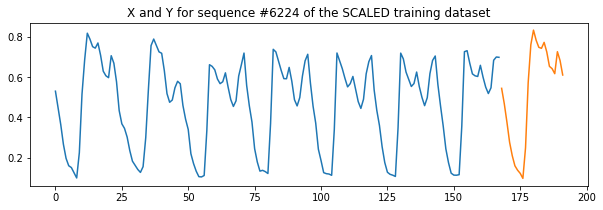

In [12]:
f, ax = plt.subplots(1,figsize=(10,3))
ax.plot(np.arange(T),X_tra[random_ix], label='Xtra')
ax.plot(np.arange(T,T+H),Y_tra[random_ix], label = 'Ytra')
ax.set_title(f'X and Y for sequence #{random_ix} of the SCALED training dataset');

Before proceeding with the assignment, we now we create scaled sequences for the test dataset.

In [13]:
# create
X_tst,Y_tst=assignment_utils.create_sequences(df_year2.values.reshape(-1),T=T,H=H)
print(X_tst.shape)
print(Y_tst.shape)

# normalize
X_tst, _ = assignment_utils.scale_sequences(X_tst, scaler)
Y_tst, _ = assignment_utils.scale_sequences(Y_tst, scaler)

(8568, 168)
(8568, 24)


### <u>BEGINNING OF ASSIGNMENT</u>

#### Part 1. Train a Feed-forward Neural Network that will be used as benchmark.

You are asked to train several FNNs architectures (between 10 and 20) to develop a good benchmark for the *water demand forecasting problem*.

_Instructions_
- Try single hidden layer as well as double hidden layer FNNs;
- Try different activation functions for the hidden layer (e.g., ```ReLU```, ```tanh```); keep the output activation function ```linear```;
- Limit the total number of neurons in each layer to 100;
- Use ```dropout``` and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 10 minutes for each model;
- Save all models (e.g., using the model checkpoint callback);
- Use the ```Adam``` optimizer, and set learning rate to 0.005;
- Use a batch size of 32.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the benchmark architecture and motivate why.
- Plot the training/validation history of the selected FNN architecture

In [25]:
#In this code cell everything is imported and all the preliminary work is done

from keras.layers import Dense, Flatten
import keras
from keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow_addons.callbacks import TimeStopping
import tensorflow.keras.backend as K
from time import time

def get_trainable_parameters(model):
  # this quickly gets weights for each layer
  number_of_weights = [K.count_params(w) for w in model.trainable_weights]
  # loop all layers for more details
  k = 0
  for layer in model.layers:
 #   print('_ _ _ '*10)
 #   print(layer.name)
    for weights in layer.trainable_weights:
  #    print(f'{weights.name}, \nshape={weights.shape} ===> {number_of_weights[k]}')
      k+=1
  #print('_ _ _ '*10)
  total = np.array(number_of_weights).sum().astype(int)
 # print(f'Total = {total}')
  return total

earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, 
                              min_delta=1e-4, mode='auto', restore_best_weights=True)
timeStopping = TimeStopping(seconds=600, verbose=1)


#initialise empty variables
number_of_parameters = []
i = 0

batch_size = 32 # number of samples processed before the model is updated
num_epochs = 200  # number of complete passes through the training dataset before the training stops

modeldescriptions = []
total_times = []
lowest_validation_loss = []

In [59]:
#A code cell which can be run time and time again to gather more and more different models

model_name = 'FNN_model_{}_weights.hdf5'.format(i)
modelCheckpoint = ModelCheckpoint(model_name, save_best_only=True, monitor='val_loss', 
                                  mode='auto', save_weights_only=True)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(50, activation=tf.nn.tanh))
model.add(tf.keras.layers.Dropout(.05))
model.add(BatchNormalization())
#model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
#model.add(tf.keras.layers.Dropout(.2))
#model.add(BatchNormalization())
model.add(tf.keras.layers.Dense(24))


# Compiling the model adds a loss function, optimiser and metrics to track during training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.005),
              loss='mse',
              metrics=['accuracy'])

start = time()
history = model.fit(x = X_tra, y = Y_tra, epochs=num_epochs, batch_size=batch_size, validation_data=(X_val, Y_val),callbacks = [earlyStopping, modelCheckpoint, timeStopping])
total_times.append(time()-start)
number_of_parameters.append(get_trainable_parameters(model))
modeldescriptions.append('This is model {} with 1 hidden layers (50), 5% dropout, and tanh activation'.format(i))
lowest_validation_loss.append(min(history.history["val_loss"]))
print('Number of parameters: ', number_of_parameters[i])
model.summary()
i = i+1

Epoch 1/200
228/228 [==============================] - 2s 5ms/step - loss: 0.0940 - accuracy: 0.0985 - val_loss: 0.0095 - val_accuracy: 0.1858
Epoch 2/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0129 - accuracy: 0.1360 - val_loss: 0.0058 - val_accuracy: 0.2216
Epoch 3/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0081 - accuracy: 0.1855 - val_loss: 0.0047 - val_accuracy: 0.2473
Epoch 4/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0066 - accuracy: 0.2194 - val_loss: 0.0043 - val_accuracy: 0.2582
Epoch 5/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0060 - accuracy: 0.2308 - val_loss: 0.0042 - val_accuracy: 0.2597
Epoch 6/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0055 - accuracy: 0.2509 - val_loss: 0.0050 - val_accuracy: 0.2683
Epoch 7/200
228/228 [==============================] - 1s 5ms/step - loss: 0.0055 - accuracy: 0.2567 - val_loss: 0.0039 - val_accuracy: 0.2807

In [96]:
print('Number of parameters: ', number_of_parameters)
print(modeldescriptions)
print(total_times)
print(lowest_validation_loss)

min_model = np.argmin(lowest_validation_loss)
print()
print('The model with the lowest validation loss was model',min_model, 'with validation loss',lowest_validation_loss[min_model-1],'and training time of',total_times[min_model-1],'seconds wherin it trained',number_of_parameters[min_model-1],'parameters. The model description is as follows:',modeldescriptions[min_model-1])

Number of parameters:  [4819.0, 2659.0, 10499.0, 12424.0, 14349.0, 20499.0, 26649.0, 23049.0, 23049.0, 23049.0, 23049, 23049.0, 29824.0, 19524.0, 14649, 9774]
['This is model 1 with 2 hidden layers (10 and 10), 2 times 20% dropout, and relu activation', 'This is model 2 with 2 hidden layers (10 and 25), 2 times 20% dropout, and relu activation', 'This is model 3 with 2 hidden layers (50 and 25), 2 times 20% dropout, and relu activation', 'This is model 4 with 2 hidden layers (50 and 50), 2 times 20% dropout, and relu activation', 'This is model 5 with 2 hidden layers (50 and 75), 2 times 20% dropout, and relu activation', 'This is model 6 with 2 hidden layers (75 and 75), 2 times 20% dropout, and relu activation', 'This is model 7 with 2 hidden layers (100 and 75), 2 times 20% dropout, and relu activation', 'This is model 8 with 2 hidden layers (75 and 100), 2 times 20% dropout, and relu activation', 'This is model 9 with 2 hidden layers (75 and 100), 2 times 20% dropout, and tanh then

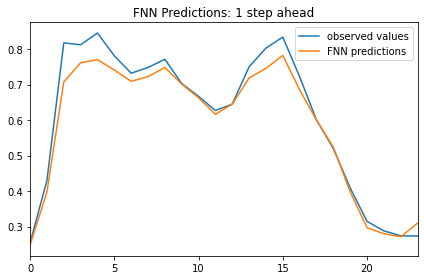

In [94]:
## Plot to indicate how well the model fits
# setup plots
f, axes = plt.subplots(1,1)

# predict (1 step ahead)
FNN_val_pred = model.predict(X_val)

# plot predictions
axes.plot(Y_val[0], label='observed values')
axes.plot(FNN_val_pred[0], label='FNN predictions')
axes.set_title('FNN Predictions: 1 step ahead')
axes.set_xlim([0,23])
axes.legend()
f.tight_layout()

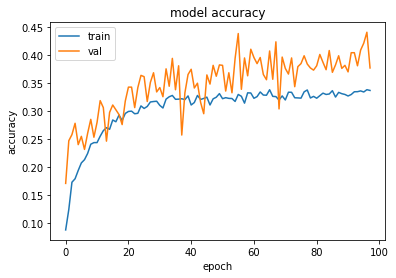

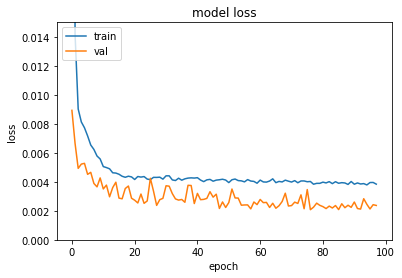

In [92]:
#Plotting accuracy and validation accuracy plus loss and validation loss of the model

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
ax = plt.gca()
ax.set_ylim([0,0.015])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##Reasoning

Model 11 was chosen because it gave the lowest validation loss. Since the FNN is probably not going to be competition for the RNN, we chose to only consider which FNN gives the best result instead of also considering training time and number of parameters. If we wanted to use the model for real water demand forecasting we might choose a different model based on those requirements.

#### Part 2. Train multiple Recurrent Neural Networks architectures.

You are asked to train several RNNs architectures (between 10 and 20) to identify a suitable model for *water demand forecasting problem*.

_Instructions_
- Try SimpleRNN as well as LSTM;
- You can also try GRU and/or double-layered RNNs;
- Try different activation functions for the hidden layer (e.g., ```ReLU```, ```tanh```); keep the output activation function ```linear```
- Limit the total number of neurons to 100 for layer;
- Use dropout and early stopping (callback) to reduce overfitting;
- Limit training epochs to 200 and use time stopping (callback) to reduce computational time to a max of 10 minutes for each model;
- Save all models (e.g., using the model checkpoint callback) 
- Use the ```Adam``` optimizer, and set learning rate to 0.005;
- Use a batch size of 32.

_Questions_
- For each trained architecture, store the *best value for the validation loss*, *number of trainable parameters*, and *training time*;
- Select the most promising architecture and motivate why. 
- Did SimpleRNN units largely underperform more advanced RNNs such as LSTM? If so, why? If not, what can be the reason?
- Plot the training/validation history of the selected RNN architecture;



#### Part 3. <u> Compare best FNN and RNN models </u>.

You will now compare the results and predictions of the best FNN and RNN models on the test dataset.

_Instructions_
- Load the best FNN and RNN models.
- Use the models to predict water demands for the training, validation and test dataset.
- Visually compare the output of the two models on the test dataset. This can be done by plotting predictions and prediction errors for 5 randomly selected sequences of the test dataset.
- Quantitatively compare the two models by computing the ```mean_absolute_error``` for the training, validation and test dataset.
- <u> Remember to scale back predictions and observations using the ```inverse_transform``` method of the scaler.</u>

_Questions_
- Do RNNs outperform FNNs? How did you compare them?
- How does the test ```mean_absolute_error``` compare to that measured during training and validation? Do you think the models might be overfitting?
- If so, do you think it happens because of model limitations or because of the datasets used?
